In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optimizers
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision import datasets
import torchvision.transforms as transforms
from callbacks import EarlyStopping

In [6]:
class DNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.l1 = nn.Linear(input_dim, hidden_dim)
        self.a1 = nn.ReLU()
        self.d1 = nn.Dropout(0.5)
        self.l2 = nn.Linear(hidden_dim, hidden_dim)
        self.a2 = nn.ReLU()
        self.d2 = nn.Dropout(0.5)
        self.l3 = nn.Linear(hidden_dim, hidden_dim)
        self.a3 = nn.ReLU()
        self.d3 = nn.Dropout(0.5)
        self.l4 = nn.Linear(hidden_dim, output_dim)

        self.layers = [self.l1, self.a1, self.d1,
                       self.l2, self.a2, self.d2,
                       self.l3, self.a3, self.d3,
                       self.l4]

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)

        return x

In [7]:
if __name__ == '__main__':
    np.random.seed(123)
    torch.manual_seed(123)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    '''
    1. データの準備
    '''
    root = os.path.join('~', '.torch', 'mnist')
    transform = transforms.Compose([transforms.ToTensor(),
                                    lambda x: x.view(-1)])
    mnist_train = datasets.MNIST(root=root,
                                 download=True,
                                 train=True,
                                 transform=transform)
    mnist_test = datasets.MNIST(root=root,
                                download=True,
                                train=False,
                                transform=transform)

    n_samples = len(mnist_train)
    n_train = int(n_samples * 0.8)
    n_val = n_samples - n_train

    mnist_train, mnist_val = \
        random_split(mnist_train, [n_train, n_val])

    train_dataloader = DataLoader(mnist_train,
                                  batch_size=100,
                                  shuffle=True)
    val_dataloader = DataLoader(mnist_val,
                                batch_size=100,
                                shuffle=False)
    test_dataloader = DataLoader(mnist_test,
                                 batch_size=100,
                                 shuffle=False)

    '''
    2. モデルの構築
    '''
    model = DNN(784, 200, 10).to(device)

    '''
    3. モデルの学習
    '''
    criterion = nn.CrossEntropyLoss()
    optimizer = optimizers.SGD(model.parameters(), lr=0.01)

    def compute_loss(t, y):
        return criterion(y, t)

    def train_step(x, t):
        model.train()
        preds = model(x)
        loss = compute_loss(t, preds)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        return loss, preds

    def val_step(x, t):
        model.eval()
        preds = model(x)
        loss = criterion(preds, t)

        return loss, preds

    epochs = 1000
    hist = {'val_loss': [], 'val_accuracy': []}
    es=EarlyStopping(patience=5,verbose=1)

    for epoch in range(epochs):
        train_loss = 0.
        train_acc = 0.
        val_loss = 0.
        val_acc = 0.

        for (x, t) in train_dataloader:
            x, t = x.to(device), t.to(device)
            loss, preds = train_step(x, t)
            train_loss += loss.item()
            train_acc += \
                accuracy_score(t.tolist(),
                               preds.argmax(dim=-1).tolist())

        train_loss /= len(train_dataloader)
        train_acc /= len(train_dataloader)

        for (x, t) in val_dataloader:
            x, t = x.to(device), t.to(device)
            loss, preds = val_step(x, t)
            val_loss += loss.item()
            val_acc += \
                accuracy_score(t.tolist(),
                               preds.argmax(dim=-1).tolist())

        val_loss /= len(val_dataloader)
        val_acc /= len(val_dataloader)

        hist['val_loss'].append(val_loss)
        hist['val_accuracy'].append(val_acc)

        print('epoch: {}, loss: {:.3}, acc: {:.3f}'
              ', val_loss: {:.3}, val_acc: {:.3f}'.format(
                  epoch+1,
                  train_loss,
                  train_acc,
                  val_loss,
                  val_acc
              ))
        if es(val_loss):
            break



epoch: 1, loss: 2.29, acc: 0.138, val_loss: 2.28, val_acc: 0.213
epoch: 2, loss: 2.25, acc: 0.265, val_loss: 2.16, val_acc: 0.482
epoch: 3, loss: 1.94, acc: 0.410, val_loss: 1.38, val_acc: 0.633
epoch: 4, loss: 1.3, acc: 0.553, val_loss: 0.871, val_acc: 0.727
epoch: 5, loss: 1.0, acc: 0.661, val_loss: 0.669, val_acc: 0.805
epoch: 6, loss: 0.826, acc: 0.731, val_loss: 0.539, val_acc: 0.845
epoch: 7, loss: 0.708, acc: 0.777, val_loss: 0.461, val_acc: 0.868
epoch: 8, loss: 0.626, acc: 0.807, val_loss: 0.407, val_acc: 0.885
epoch: 9, loss: 0.567, acc: 0.830, val_loss: 0.372, val_acc: 0.894
epoch: 10, loss: 0.523, acc: 0.845, val_loss: 0.343, val_acc: 0.901
epoch: 11, loss: 0.486, acc: 0.856, val_loss: 0.318, val_acc: 0.908
epoch: 12, loss: 0.456, acc: 0.866, val_loss: 0.302, val_acc: 0.914
epoch: 13, loss: 0.429, acc: 0.876, val_loss: 0.283, val_acc: 0.919
epoch: 14, loss: 0.408, acc: 0.883, val_loss: 0.27, val_acc: 0.921
epoch: 15, loss: 0.389, acc: 0.890, val_loss: 0.254, val_acc: 0.926


epoch: 121, loss: 0.0917, acc: 0.973, val_loss: 0.0918, val_acc: 0.975
epoch: 122, loss: 0.0898, acc: 0.973, val_loss: 0.0896, val_acc: 0.975
epoch: 123, loss: 0.0899, acc: 0.973, val_loss: 0.0912, val_acc: 0.975
epoch: 124, loss: 0.0877, acc: 0.974, val_loss: 0.0917, val_acc: 0.974
epoch: 125, loss: 0.0903, acc: 0.974, val_loss: 0.0919, val_acc: 0.975
epoch: 126, loss: 0.0883, acc: 0.975, val_loss: 0.0921, val_acc: 0.975
epoch: 127, loss: 0.09, acc: 0.974, val_loss: 0.0914, val_acc: 0.975
epoch: 128, loss: 0.0833, acc: 0.976, val_loss: 0.0933, val_acc: 0.975
early stopping


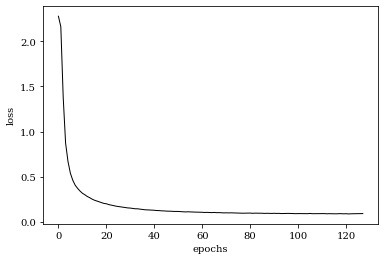

test_loss: 0.087, test_acc: 0.976


In [8]:
   
    '''
    4. モデルの評価
    '''
    # 検証データの誤差の可視化
    val_loss = hist['val_loss']

    fig = plt.figure()
    plt.rc('font', family='serif')
    plt.plot(range(len(val_loss)), val_loss,
             color='black', linewidth=1)
    plt.xlabel('epochs')
    plt.ylabel('loss')
    # plt.savefig('output.jpg')
    plt.show()

    # 正解率を可視化する場合
    # val_acc = hist['val_accuracy']
    #
    # fig = plt.figure()
    # plt.rc('font', family='serif')
    # plt.plot(range(len(val_acc)), val_acc,
    #          color='black', linewidth=1)
    # plt.xlabel('epochs')
    # plt.ylabel('acc')
    # plt.savefig('output_acc.jpg')
    # plt.show()

    # テストデータの評価
    def test_step(x, t):
        return val_step(x, t)

    test_loss = 0.
    test_acc = 0.

    for (x, t) in test_dataloader:
        x, t = x.to(device), t.to(device)
        loss, preds = test_step(x, t)
        test_loss += loss.item()
        test_acc += \
            accuracy_score(t.tolist(),
                           preds.argmax(dim=-1).tolist())

    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)
    print('test_loss: {:.3f}, test_acc: {:.3f}'.format(
        test_loss,
        test_acc
    ))